# Terrain Prices

@roman 

9 July, 2024

Estimare the value of the land in space



In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import h3
from shapely.geometry import Polygon
from tqdm import tqdm

from INEGIpy import MarcoGeoestadistico


In [2]:
# settings
pd.options.display.max_columns = 120
geo_framework = MarcoGeoestadistico()

# params
HEX_RESOLUTION = 8

---
# Data

## Read

In [3]:
# properties
gdf_properties = gpd.read_parquet('../../data/interim/cleaned_data_s6.parquet')

# get only importnat columns
cols_to_stay = [
    'property_id', 'fecha_avaluo', 'id_clase_inmueble',
    'superficie_terreno', 'valor_fisico_terreno_m2', 'property_type', 'city_cluster',
    'geometry'
]

# subset to important columns
gdf_properties = gdf_properties[cols_to_stay]

# crs to 4326
gdf_properties = gdf_properties.to_crs(epsg=4326)

# get longitude and latitude
gdf_properties['longitude'] = gdf_properties['geometry'].x
gdf_properties['latitude'] = gdf_properties['geometry'].y

# see
print(gdf_properties.shape)
gdf_properties.head()

(852913, 10)


property_id fecha_avaluo  id_clase_inmueble  \
0  66cf10199ef943a5a5ff82129e53d5d7   2020-05-27                  4   
1  f84f9a0c784f491eab6bb100b513a95b   2020-07-23                  3   
2  7ddd5a94feed4955a809f986d95722d8   2020-10-05                  4   
3  d2e75fb3b385461995bf8d34b9d1fdfb   2020-10-22                  4   
4  6f1194f9853443219e63f4a3222b010e   2020-05-27                  4   

   superficie_terreno  valor_fisico_terreno_m2 property_type  city_cluster  \
0                 143                   8918.0         house             0   
1                 113                   6151.0         house             0   
2                 200                   5620.0         house             0   
3                 107                  18149.0         house             0   
4                  84                   4544.8         house             0   

                     geometry  longitude   latitude  
0  POINT (-99.15810 19.31088) -99.158103  19.310875  
1  POINT (-99.06536 19.49172) -99.065361  19.491722  
2  POINT (-99.21354 19.63339) -99.213541  19.633393  
3  POINT (-99.11453 19.33306) -99.114525  19.333061  
4  POINT (-99.05283 19.48659) -99.052833  19.486586

In [4]:
# get cities
gdf_cities = gpd.read_parquet('../../data/misc/polygons_cities_analysis.parquet')

# crs to 4326
gdf_cities = gdf_cities.to_crs(epsg=4326)

# see
print(gdf_cities.shape)
gdf_cities.head()

(158, 4)


city_cluster                                           geometry  \
0             0  POLYGON ((-99.11495 19.23685, -99.23677 19.267...   
1             1  POLYGON ((-110.94218 28.99061, -110.96833 28.9...   
2             2  POLYGON ((-89.68166 20.87908, -89.71265 20.904...   
3             3  POLYGON ((-109.94225 22.87781, -109.95412 22.8...   
4             4  POLYGON ((-97.84911 22.20222, -97.85072 22.202...   

  id_entidad_f id_municipio  
0           09          003  
1           26          030  
2           31          050  
3           03          008  
4           28          003

<Axes: >

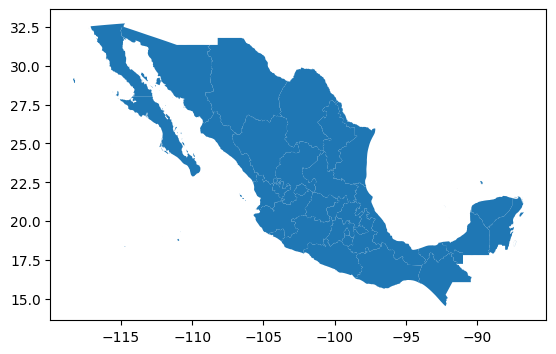

In [5]:
# get mexico shape
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.plot()

[]

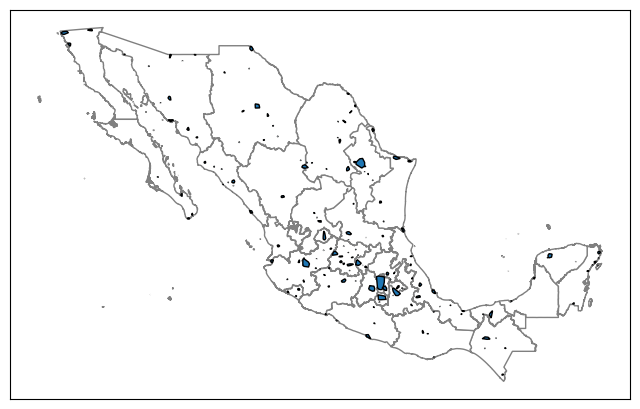

In [6]:
# plot cities
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
gdf_mex_states.plot(ax=ax, color='white', edgecolor='gray')
gdf_cities.plot(ax=ax, color='C0', edgecolor='black')

# eliminate ticks
ax.set_xticks([])
ax.set_yticks([])

## Wrangle

In [7]:
# Ensure we use lat/lon coordinates
def to_latlon(gdf):
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    return gdf


# Get all H3 hexagons covering a shapely geometry
def h3_polyfill(geometry, resolution):
    hexagons = set()
    if geometry.geom_type == 'Polygon':
        hexagons.update(h3.polyfill(geometry.__geo_interface__, resolution, geo_json_conformant=True))
    elif geometry.geom_type == 'MultiPolygon':
        for poly in geometry:
            hexagons.update(h3.polyfill(poly.__geo_interface__, resolution, geo_json_conformant=True))
    return hexagons


# Create GeoDataFrame of H3 hexagons from a set of H3 indices
def hexagons_to_geodf(hexagons, crs):
    # each hexagon to polygon
    polygons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    # create geodataframe
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf


# Vectorized function to compute hexagons
def create_hex_grid_vectorized(gdf, resolution):
    # copy
    gdf = gdf.copy()

    # buffer by 1km the geometries
    gdf = gdf.to_crs('EPSG:6372')
    gdf['geometry'] = gdf['geometry'].buffer(1_000)

    # Convert GeoDataFrame to lat/lon if not already
    gdf = to_latlon(gdf)

    # Get H3 hexagons for all geometries
    hex_sets = np.array([h3_polyfill(geom, resolution) for geom in gdf['geometry']])
    
    # Flatten the hexagon sets
    all_hexagons = set().union(*hex_sets)

    # Convert H3 indices to GeoDataFrame
    hex_gdf = hexagons_to_geodf(all_hexagons, gdf.crs)

    # Add h3 index
    hex_gdf['hex_id'] = hex_gdf.apply(
        lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, resolution),
        axis=1
        )
    
    # Merge with gdf to get the city
    hex_gdf = (
        hex_gdf
        .sjoin(gdf[['city_cluster', 'geometry']], how='left', predicate='intersects')
        # drop duplicates
        .drop_duplicates(subset='hex_id')
        .drop(columns='index_right')
        .reset_index(drop=True)
    )

    return hex_gdf


# Create the hexagon grid
hex_gdf = create_hex_grid_vectorized(gdf_cities, HEX_RESOLUTION)

# See
print(hex_gdf.shape)
hex_gdf.head()


(31392, 3)


geometry           hex_id  \
0  POLYGON ((-101.20204 20.58967, -101.19748 20.5...  884983865bfffff   
1  POLYGON ((-103.40811 20.46108, -103.40358 20.4...  8849aa252bfffff   
2  POLYGON ((-89.70512 21.04751, -89.70065 21.050...  884509b545fffff   
3  POLYGON ((-99.79025 16.86321, -99.78582 16.866...  8849b5401dfffff   
4  POLYGON ((-102.59619 22.75798, -102.59157 22.7...  88498861cdfffff   

   city_cluster  
0            81  
1            21  
2             2  
3            56  
4            41

In [8]:
def latlon_to_h3(latitudes, longitudes, resolution):
    """
    Convert latitude and longitude arrays to H3 hexagon IDs at a given resolution.
    
    Parameters:
    - latitudes: numpy array of latitudes
    - longitudes: numpy array of longitudes
    - resolution: H3 resolution
    
    Returns:
    - numpy array of H3 hexagon IDs
    """
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

# Get hex id for each property
gdf_properties['hex_id'] = latlon_to_h3(
    gdf_properties['latitude'].values,
    gdf_properties['longitude'].values,
    HEX_RESOLUTION
)

In [9]:
# Create log terrain value
gdf_properties['log_valor_fisico_terreno_m2'] = np.log(gdf_properties['valor_fisico_terreno_m2'])

## Mini EDA

In [10]:
# count # of hexagons per city
hex_gdf['city_cluster'].value_counts()

city_cluster
0      3646
12     2273
21     1606
31     1349
42     1319
       ... 
157      10
79        9
130       9
78        7
116       6
Name: count, Length: 158, dtype: int64

In [11]:
# look nans
hex_gdf['city_cluster'].isna().sum()

0

---
# KRing Smoothing

## S1: Unpooling

In [12]:
# aggregate mean & std of terrain value by hexagon
gdf_unpooled = (
    gdf_properties
    .groupby(['city_cluster', 'hex_id'], as_index=False)
    .agg(
        mean_log_valor_fisico_terreno_m2=('log_valor_fisico_terreno_m2', 'mean'),
        std_log_valor_fisico_terreno_m2=('log_valor_fisico_terreno_m2', 'std'),
        num_properties=('property_id', 'count')
    )
)

# see
print(gdf_unpooled.shape)
gdf_unpooled.head()

(14138, 5)


city_cluster           hex_id  mean_log_valor_fisico_terreno_m2  \
0             0  884982cb09fffff                          6.817301   
1             0  884982cb41fffff                          7.369176   
2             0  884982cb43fffff                          7.290481   
3             0  884982cb45fffff                          7.870680   
4             0  884982cb47fffff                          7.365057   

   std_log_valor_fisico_terreno_m2  num_properties  
0                         0.365092               5  
1                         0.390261              11  
2                         0.280612               4  
3                         0.516860               3  
4                         0.391495               8

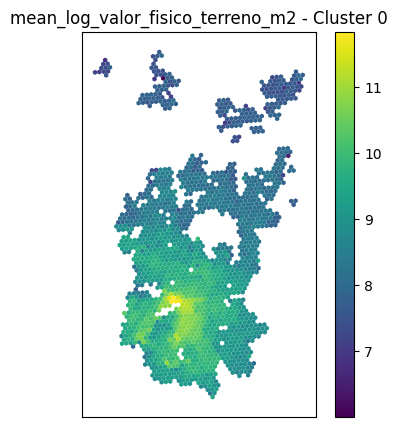

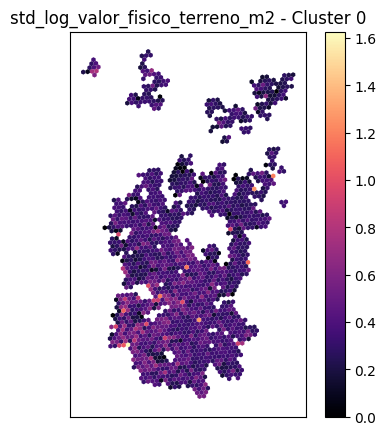

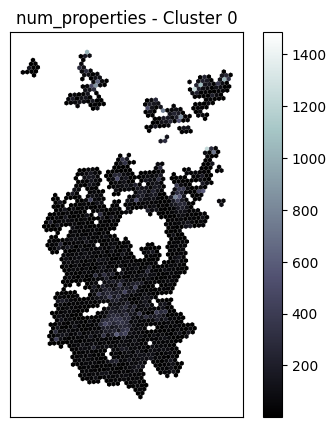

In [13]:
# plot mean, std and counts
def plot_hexagons(gdf, column, cluster, cmap='viridis'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # plot
    (
        gdf
        .query('city_cluster == @cluster')
        .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
        .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
        .plot(
            ax=ax,
            column=column,
            cmap=cmap,
            legend=True,
        )
    )

    # add title
    ax.set_title(f"{column} - Cluster {cluster}")
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

# plot mean, std and counts
cols_to_plot = [
    'mean_log_valor_fisico_terreno_m2',
    'std_log_valor_fisico_terreno_m2',
    'num_properties'
]
map_cmap = {
    'mean_log_valor_fisico_terreno_m2': 'viridis',
    'std_log_valor_fisico_terreno_m2': 'magma',
    'num_properties': 'bone'
}
cluster_name = 0

for col in cols_to_plot:
    plot_hexagons(
        gdf_unpooled,
        col,
        cluster=cluster_name,
        cmap=map_cmap[col]
    )


## S2: Smoothing

In [14]:
# weighted mean & std
def mle_weighted_stats(m, s, w, n):
    """
    Compute the weighted mean and standard deviation using the MLE formulas for the normal distribution.

    m: mean
    s: standard deviation
    w: weights
    n: number of observations
    """
    # get indexes where s > 0 
    idxs = s > 0

    # estimates
    s2 = s**2
    mle_weights = w * (n / s2)

    # pooled mean
    # p_mean =(
    #     np.sum(mle_weights[idxs] * m[idxs])
    #     + np.sum(w[~idxs] * m[~idxs])
    # )
    # p_mean /= (np.sum(mle_weights[idxs]) + np.sum(w[~idxs] + n[~idxs]))

    # weights = w * np.log(n)
    weights = w * n
    p_mean = np.sum(weights * m) / np.sum(weights)  # TODO: change estimator for one that includes sigma!

    # pooled std
    p_var = (
        np.sum(w[idxs] * ((n[idxs] - 1) * s2[idxs] + n[idxs] * (m[idxs] - p_mean)**2))
        + np.sum(w[~idxs] * n[~idxs] * (m[~idxs] - p_mean)**2)
    )
    p_var /= np.sum(w * n)

    return pd.Series({'w_mean': p_mean, 'w_std': np.sqrt(p_var), 'num_properties': np.sum(n)})


def get_h3_distance(hex_id, hex_ring, meters_factor):
    """
    Get the distance in meters between a hexagon and a ring of hexagons.
    """
    return h3.h3_distance(hex_id, hex_ring) * meters_factor


def get_distance_weight(d, xi=0.1):
    """
    Get the weight of a distance using an exponential decayment by 100m
    """
    return np.exp(-xi * d / 100)

In [15]:
def kring_smoothing(df_obj, df_data, city_cluster, metric_col='log_valor_fisico_terreno_m2', k_rings=3, distance_decayment=1):
    """
    Performs k-ring smoothing on the provided dataframes.

    Parameters:
        df_obj (DataFrame): DataFrame containing hexagon IDs and other related data.
        df_data (DataFrame): DataFrame containing data to be smoothed.
        city_cluster (int): City cluster value to filter the data.
        metric_col (str): Column name to be used for smoothing.
        k_rings (int): Number of k-rings for smoothing.
        distance_decayment (float): Decayment factor for distance weighting.

    Returns:
        DataFrame: Smoothed DataFrame.
    """
    
    # Subset the dataframes based on city_cluster
    df_obj = df_obj.query(f"city_cluster == {city_cluster}").reset_index(drop=True)
    df_data = df_data.query(f"city_cluster == {city_cluster}").reset_index(drop=True)

    # Define parameters
    distance_resolution_h3 = h3.edge_length(HEX_RESOLUTION, 'm')

    # Step 1: Generate DataFrame of only hex_ids
    df_k = df_obj[['hex_id']]
    df_k.index = df_k['hex_id']

    # Step 2: Explode k-rings
    df_k = (df_k.loc[:, 'hex_id']
            .apply(lambda x: pd.Series(list(h3.k_ring(x, k_rings))))
            .stack()
            .to_frame('hex_k')
            .reset_index(1, drop=True)
            .reset_index())

    # Step 3: Merge with df_data
    df_k = (df_k.merge(df_data, left_on='hex_k', right_on='hex_id', how='left', suffixes=('', '_k'))
                .drop(columns='hex_id_k'))

    # Step 4: Get distance in meters between hex_id and hex_k
    df_k['distance_m'] = df_k.apply(
        lambda x: get_h3_distance(x['hex_id'], x['hex_k'], meters_factor=distance_resolution_h3), axis=1
    )

    # Step 5: Get distance weight
    df_k = df_k.assign(
        unorm_weight=lambda x: x['distance_m'].apply(lambda x: get_distance_weight(x, xi=distance_decayment)),
        unorm_weight_nan=lambda x: np.where(x['num_properties'].gt(0), x['unorm_weight'], np.nan),
        weight=lambda x: x['unorm_weight_nan'] / x.groupby('hex_id')['unorm_weight_nan'].transform('sum')
    )

    # Step 6: Get weighted statistics
    df_summary = (df_k.groupby('hex_id', as_index=False)
                      .apply(lambda x: mle_weighted_stats(
                          m=x[f"mean_{metric_col}"],
                          s=x[f"std_{metric_col}"],
                          w=x['weight'],
                          n=x['num_properties']
                      ), include_groups=False))

    return df_summary


In [16]:
# do kring smoothing for each cluster
cluster_list = gdf_unpooled['city_cluster'].unique()

# params
k_rings = 3
distance_decayment = 1

# smoothing
list_smoothed = []

for cluster in tqdm(cluster_list):
    smoothed = kring_smoothing(
        df_obj=hex_gdf,
        df_data=gdf_unpooled,
        city_cluster=cluster,
        metric_col='log_valor_fisico_terreno_m2',
        k_rings=k_rings,
        distance_decayment=distance_decayment
    )
    smoothed['city_cluster'] = cluster
    list_smoothed.append(smoothed)

# concat
gdf_smoothed = pd.concat(list_smoothed, ignore_index=True)

  0%|          | 0/158 [00:00<?, ?it/s]/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_5305/777877878.py:27: RuntimeWarning: invalid value encountered in scalar divide
  p_mean = np.sum(weights * m) / np.sum(weights)
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_5305/777877878.py:34: RuntimeWarning: invalid value encountered in scalar divide
  p_var /= np.sum(w * n)
  3%|▎         | 4/158 [00:14<05:57,  2.32s/it]/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_5305/777877878.py:27: RuntimeWarning: invalid value encountered in scalar divide
  p_mean = np.sum(weights * m) / np.sum(weights)
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_5305/777877878.py:34: RuntimeWarning: invalid value encountered in scalar divide
  p_var /= np.sum(w * n)
  3%|▎         | 5/158 [00:15<04:33,  1.79s/it]/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_5305/777877878.py:27: RuntimeWarning: invalid value encountered in scalar divide
  p_mean = np.sum(w

## S3: Explore

In [17]:
# see
print(gdf_smoothed.shape)
gdf_smoothed.head()

(31392, 5)


hex_id    w_mean     w_std  num_properties  city_cluster
0  884982cb01fffff  6.831288  0.337543           178.0             0
1  884982cb05fffff  7.158186  0.441847            31.0             0
2  884982cb09fffff  6.831290  0.337545           196.0             0
3  884982cb0bfffff  6.831288  0.337543           178.0             0
4  884982cb0dfffff  7.158480  0.441818           191.0             0

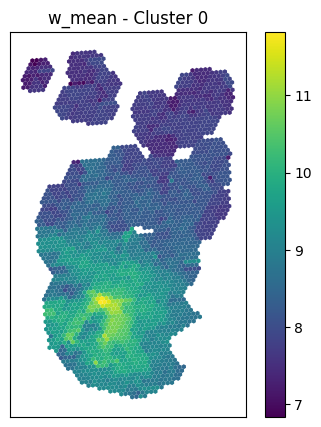

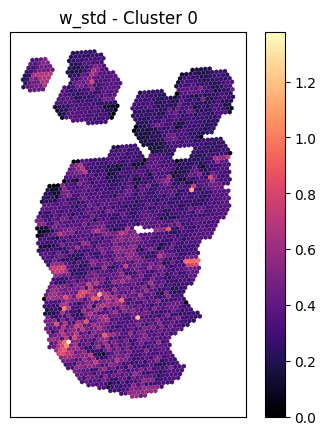

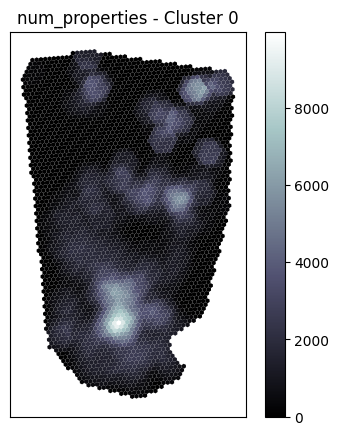

In [18]:
# plot
cols_to_plot = [
    'w_mean',
    'w_std',
    'num_properties'
]
map_cmap = {
    'w_mean': 'viridis',
    'w_std': 'magma',
    'num_properties': 'bone'
}

for col in cols_to_plot:
    plot_hexagons(
        gdf_smoothed,
        col,
        cluster=cluster_name,
        cmap=map_cmap[col]
    )

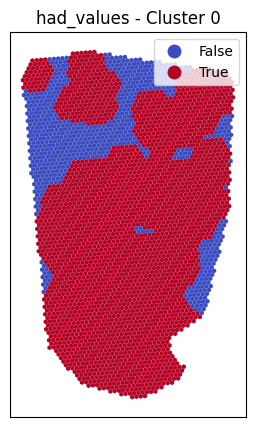

In [19]:
# plot hexagons that didt have values
plot_hexagons(
    gdf_smoothed.assign(had_values=lambda x: x['num_properties'].gt(0)),
    'had_values',
    cluster=cluster_name,
    cmap='coolwarm'
)

In [20]:
# see how many hexagons had values
print(gdf_smoothed['num_properties'].gt(0).sum())
print(gdf_smoothed['num_properties'].gt(0).mean())


27952
0.8904179408766565


---
# Expansion

## S1: Expand

In [21]:
# expand mean & std
def expand_stats(m, s, w, n, lamb, m_min, s_max, punishment=0.5):
    """
    Expand the mean and standard deviation of a distribution by a factor lambda.

    m: mean
    s: standard deviation
    w: weights
    lamb: factor to expand
    m_min: minimum mean
    s_max: maximum standard deviation
    punishment: factor to punish
    """
    # find how many info there is
    sum_lambda = np.sum(lamb)
    if sum_lambda == 0:
        return pd.Series({
            'w_mean': m_min * punishment,
            'w_std': s_max * punishment,
            'num_properties': 0
            })
    
    # estimates
    series_estimates = mle_weighted_stats(m, s, w, n)
    # expand
    series_estimates['w_mean'] = sum_lambda * series_estimates['w_mean'] + (1 - sum_lambda) * (m_min * punishment)
    series_estimates['w_std'] = sum_lambda * series_estimates['w_std'] + (1 - sum_lambda) * (s_max * punishment)

    # return
    return series_estimates


def expand_stats(m, s, w, n, lamb, m_min, s_max, punishment=0.5):
    """
    Expand the mean and standard deviation of a distribution by a factor lambda.

    Parameters:
        m (Series): Mean values.
        s (Series): Standard deviation values.
        w (Series): Weights.
        n (Series): Number of properties.
        lamb (Series): Lambda factor to expand.
        m_min (float): Minimum mean.
        s_max (float): Maximum standard deviation.
        punishment (float): Factor to punish.

    Returns:
        Series: Expanded statistics.
    """
    sum_lambda = np.sqrt(np.sum(lamb))
    if sum_lambda == 0:
        return pd.Series({
            'w_mean': m_min * punishment,
            'w_std': s_max * punishment,
            'num_properties': 0
        })

    series_estimates = mle_weighted_stats(m, s, w, n)
    series_estimates['w_mean'] = sum_lambda * series_estimates['w_mean'] + (1 - sum_lambda) * (m_min * punishment)
    series_estimates['w_std'] = sum_lambda * series_estimates['w_std'] + (1 - sum_lambda) * (s_max * punishment)

    return series_estimates


def kring_expand(df_obj, df_data, metric_col='log_valor_fisico_terreno_m2', k_rings=15, distance_decayment=0.1, percent_punishment=0.8):
    """
    Performs k-ring smoothing on the provided dataframes and expands statistics.

    Parameters:
        df_obj (DataFrame): DataFrame containing hexagon IDs and other related data with no properties.
        df_data (DataFrame): DataFrame containing data to be smoothed with properties.
        metric_col (str): Column name to be used for smoothing.
        k_rings (int): Number of k-rings for smoothing.
        distance_decayment (float): Decayment factor for distance weighting.
        percent_punishment (float): Punishment factor for expanding statistics.

    Returns:
        DataFrame: Smoothed and expanded DataFrame.
    """
    # copy
    df_obj = df_obj.copy()
    df_data = df_data.copy()

    # Define parameters
    distance_resolution_h3 = h3.edge_length(HEX_RESOLUTION, 'm')

    # Step 1: Generate DataFrame of only hex_ids
    df_k = df_obj[['hex_id']]
    df_k.index = df_k['hex_id']

    # Step 2: Explode k-rings
    df_k = (df_k.loc[:, 'hex_id']
            .apply(lambda x: pd.Series(list(h3.k_ring(x, k_rings))))
            .stack()
            .to_frame('hex_k')
            .reset_index(1, drop=True)
            .reset_index())

    # Step 3: Merge with df_data
    df_k = (df_k.merge(df_data, left_on='hex_k', right_on='hex_id', how='left', suffixes=('', '_k'))
                .drop(columns='hex_id_k'))

    # Step 4: Get distance in meters between hex_id and hex_k
    df_k['distance_m'] = df_k.apply(
        lambda x: get_h3_distance(x['hex_id'], x['hex_k'], meters_factor=distance_resolution_h3), axis=1
    )

    # Step 5: Get distance weight
    df_k = df_k.assign(
        unorm_weight=lambda x: x['distance_m'].apply(lambda x: get_distance_weight(x, xi=distance_decayment)),
        unorm_weight_nan=lambda x: np.where(x['num_properties'].gt(0), x['unorm_weight'], np.nan),
        weight=lambda x: x['unorm_weight_nan'] / x.groupby('hex_id')['unorm_weight_nan'].transform('sum'),
        lamb_raw=lambda x: x['unorm_weight'] / x.groupby('hex_id')['unorm_weight'].transform('sum'),
        lamb=lambda x: np.where(x['num_properties'].gt(0), x['lamb_raw'], 0)
    )

    # Step 6: Min wmean and max wstd
    min_wmean = df_data['w_mean'].min()
    max_wstd = df_data['w_std'].max()

    # Step 7: Get weighted statistics
    df_summary_expanded = (df_k.groupby('hex_id', as_index=False)
                           .apply(lambda x: expand_stats(
                               m=x['w_mean'],
                               s=x['w_std'],
                               w=x['weight'],
                               n=x['num_properties'],
                               lamb=x['lamb'],
                               m_min=min_wmean,
                               s_max=max_wstd,
                               punishment=percent_punishment
                           ), include_groups=False))

    return df_summary_expanded


def subset_data(df, cluster):
    """
    Subset data by cluster.
    """
    return (
        df
        .query(f"city_cluster == {cluster}")
        .assign(num_properties=lambda x: np.sqrt(x['num_properties']))
        .reset_index(drop=True)
        .copy()
        )


In [22]:
# subset hex with no values
gdf_smoothed_no_values = gdf_smoothed.query('num_properties == 0').reset_index(drop=True)
gdf_smoothed_with_values = gdf_smoothed.query('num_properties > 0').reset_index(drop=True)
print(f"Hex to expand: {gdf_smoothed_no_values.shape[0]}")

# do kring expand for hexagons with no values
cluster_list = gdf_smoothed_no_values['city_cluster'].unique()

# params
k_rings = 10
distance_decayment = 0.1

# expand
list_expanded = []

for cluster in tqdm(cluster_list):
    # subset
    temp_gdf_smoothed_no_values = subset_data(gdf_smoothed_no_values, cluster)
    temp_gdf_smoothed_with_values = subset_data(gdf_smoothed_with_values, cluster)

    # expand
    expanded = kring_expand(
        df_obj=temp_gdf_smoothed_no_values,
        df_data=temp_gdf_smoothed_with_values,
        metric_col='log_valor_fisico_terreno_m2',
        k_rings=k_rings,
        distance_decayment=distance_decayment,
        percent_punishment=0.8
    )
    expanded['city_cluster'] = cluster
    list_expanded.append(expanded)

# concat
gdf_expanded = pd.concat(list_expanded, ignore_index=True)
print(f"Hex expanded: {gdf_expanded.shape[0]}")

Hex to expand: 3440


100%|██████████| 38/38 [00:34<00:00,  1.09it/s]

Hex expanded: 3440


In [23]:
# concat with values
gdf_terrain_values = pd.concat([gdf_smoothed_with_values, gdf_expanded], ignore_index=True)

# see
print(gdf_terrain_values.shape)
print(hex_gdf.shape)
gdf_terrain_values.head()

(31392, 5)
(31392, 3)


hex_id    w_mean     w_std  num_properties  city_cluster
0  884982cb01fffff  6.831288  0.337543           178.0             0
1  884982cb05fffff  7.158186  0.441847            31.0             0
2  884982cb09fffff  6.831290  0.337545           196.0             0
3  884982cb0bfffff  6.831288  0.337543           178.0             0
4  884982cb0dfffff  7.158480  0.441818           191.0             0

## S2: Explore

In [24]:
# see if there are repeated hexagons
print(gdf_terrain_values['hex_id'].duplicated().sum())

0


In [25]:
# describe stats
gdf_terrain_values.loc[:, ['w_mean', 'w_std']].describe()

w_mean         w_std
count  31392.000000  31392.000000
mean       7.782122      0.337312
std        0.752291      0.153272
min        5.465031      0.000000
25%        7.348127      0.238476
50%        7.749175      0.304204
75%        8.173790      0.400874
max       11.823182      1.587733

In [26]:
# top 5 clusters with highest mean terrain value
(
    gdf_terrain_values
    .groupby('city_cluster', as_index=False)
    .agg(
        mean_w_mean=('w_mean', 'mean'),
    )
    .set_index('city_cluster')
    .sort_values('mean_w_mean', ascending=False)
    .head()
)

mean_w_mean
city_cluster             
71               8.634347
37               8.617568
38               8.479856
11               8.446113
9                8.360777

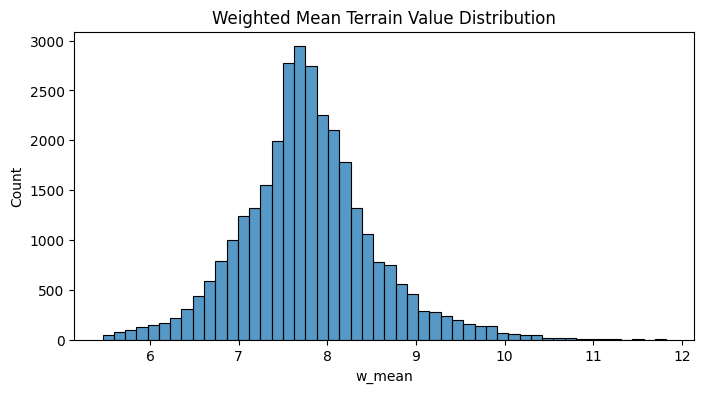

In [27]:
# plot distributions
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(gdf_terrain_values['w_mean'], bins=50, color='C0', ax=ax)
ax.set_title('Weighted Mean Terrain Value Distribution')
plt.show()

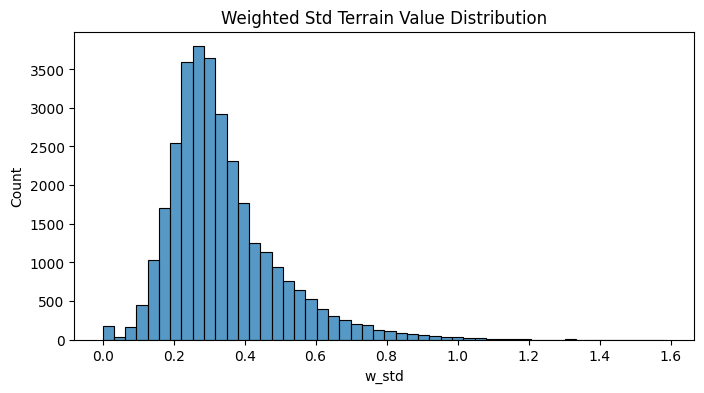

In [28]:
# plot distributions
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(gdf_terrain_values['w_std'], bins=50, color='C0', ax=ax)
ax.set_title('Weighted Std Terrain Value Distribution')
plt.show()

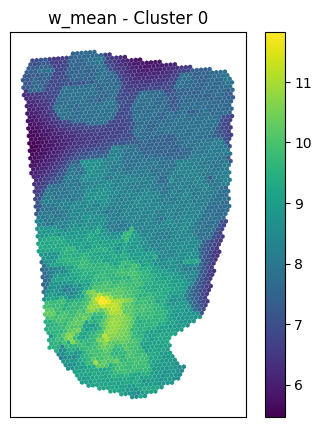

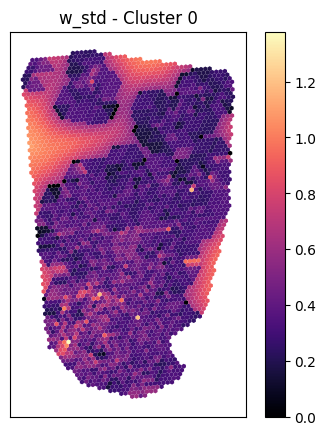

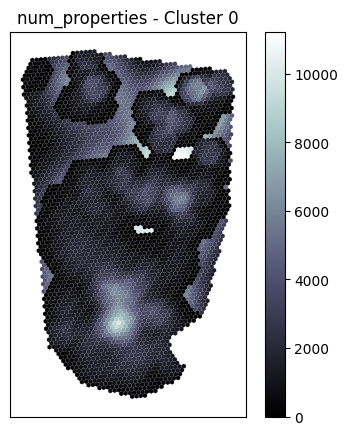

In [29]:
# plot
cols_to_plot = [
    'w_mean',
    'w_std',
    'num_properties'
]
map_cmap = {
    'w_mean': 'viridis',
    'w_std': 'magma',
    'num_properties': 'bone'
}

for col in cols_to_plot:
    plot_hexagons(
        gdf_terrain_values,
        col,
        cluster=cluster_name,
        cmap=map_cmap[col]
    )

---
# Maps

In [30]:
# unpooled
(
    gdf_unpooled
    .query("city_cluster == 0")
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'mean_log_valor_fisico_terreno_m2',
        tiles='cartodbpositron',
        legend=True
    )
)

In [31]:
# smoothed
(
    gdf_smoothed
    .query("city_cluster == 0")
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'w_mean',
        tiles='cartodbpositron',
        legend=True
    )
)

In [32]:
# terrain
(
    gdf_terrain_values
    .query("city_cluster == 0")
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'w_mean',
        tiles='cartodbpositron',
        legend=True
    )
)

---
# Save

In [38]:
# save terrain table
(
    gdf_terrain_values
    .drop(columns=['num_properties'])
    .rename(columns={
        'w_mean': 'mean_log_valor_fisico_terreno_m2',
        'w_std': 'std_log_valor_fisico_terreno_m2'
    })
    .to_parquet("../../data/misc/terrain_prices.parquet")
)

hex_id  mean_log_valor_fisico_terreno_m2  \
0      884982cb01fffff                          6.831288   
1      884982cb05fffff                          7.158186   
2      884982cb09fffff                          6.831290   
3      884982cb0bfffff                          6.831288   
4      884982cb0dfffff                          7.158480   
...                ...                               ...   
31387  884990a689fffff                          7.006138   
31388  884990a68bfffff                          6.986238   
31389  884990a68dfffff                          6.917626   
31390  884990a69dfffff                          6.904729   
31391  884990a6c7fffff                          6.967863   

       std_log_valor_fisico_terreno_m2  city_cluster  
0                             0.337543             0  
1                             0.441847             0  
2                             0.337545             0  
3                             0.337543             0  
4                             0.441818             0  
...                                ...           ...  
31387                         0.317578           140  
31388                         0.312302           140  
31389                         0.314768           140  
31390                         0.304107           140  
31391                         0.317881           140  

[31392 rows x 4 columns]

In [40]:
# terrain
m = (
    gdf_terrain_values
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'w_mean',
        tiles='cartodbpositron',
        legend=True
    )
)

# save map
m.save('../../figures/mean_log_terrain_value_ppm2.html')

In [41]:
# terrain
m = (
    gdf_terrain_values
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'w_std',
        tiles='cartodbpositron',
        legend=True,
        cmap='magma'
    )
)

# save map
m.save('../../figures/std_log_terrain_value_ppm2.html')

In [42]:
# terrain
m = (
    gdf_terrain_values
    .assign(
        exp_mean=lambda x: np.exp(x['w_mean'])
    )
    .merge(hex_gdf[['hex_id', 'geometry']], on='hex_id', how='left')
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326', geometry='geometry')
    .explore(
        'exp_mean',
        tiles='cartodbpositron',
        legend=True
    )
)

# save map
m.save('../../figures/mean_terrain_value_ppm2.html')